## Double-Well SDE and PriorVAE

In [1]:
import random as rnd

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax
import flax.linen as nn
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

from priorCVAE.priors import DoubleWellSDE
from priorCVAE.datasets import SDEDataset
from priorCVAE.models import MLPDecoder, MLPEncoder, VAE, MLPDecoderTwoHeads
from priorCVAE.trainer import VAETrainer
from priorCVAE.utility import save_model_params, load_model_params
from priorCVAE.losses import SquaredSumAndKL, NLLAndKL
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model

## Configuration

In [2]:
args = {
        # setup
        "t0" : 0,
        "t1" : 20,
        "dt" : 0.01,
        
        # architecture
        "input_dim" : None,  # This is set later depending on the time-grid
        "decoder_twoheads": False,
        "hidden_dim": [1000, 500, 100],
        "activation_fn": nn.sigmoid,
        "latent_dim": 50,
        
        # VAE training    
        "batch_size": 2000,
        "num_iterations": 40,
        "learning_rate": 1e-3,
        "vae_var": 0.1,
        "train_vae": False,
        "trained_vae_path" : "DW/priorCVAE_output/2023-07-25_01-15-06/vae_model/",
    
        # MCMC
        "num_warmup": 2000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

## Simulate the SDE and generate data

In [3]:
base_sde = DoubleWellSDE(c=2, q=3)
x_init = jnp.ones((1, 1))

sde_dataset_generator = SDEDataset(base_sde, x_init, dt=args["dt"], t_lim_high=args["t1"], t_lim_low=args["t0"]) 

In [4]:
sample_t_train, sample_y_train, _ = sde_dataset_generator.simulatedata(n_samples=100)
t_test, y_test, _ = sde_dataset_generator.simulatedata(n_samples=100)

In [5]:
args["input_dim"] = sample_y_train.shape[1]

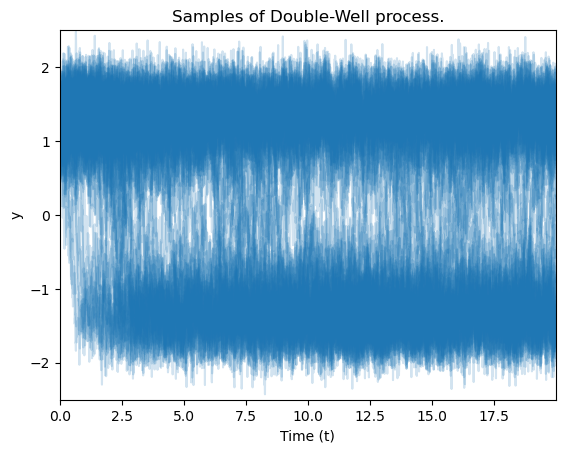

In [6]:
for y_i in sample_y_train:
    plt.plot(sample_t_train[0], y_i, color="tab:blue", alpha=0.2)

plt.xlim([sample_t_train[0][0], sample_t_train[0][-1]])
plt.ylim([-2.5, 2.5])
plt.title("Samples of Double-Well process.")
plt.xlabel("Time (t)")
plt.ylabel("y")
plt.show()

## PriorVAE model

In [7]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_iterations  = args["num_iterations"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]
decoder_twoheads = args["decoder_twoheads"]
activation_fn = args["activation_fn"]

decoder_hidden_list = hidden_dim
decoder_hidden_list.reverse()

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim, activation_fn)

if decoder_twoheads:
    decoder = MLPDecoderTwoHeads(decoder_hidden_list, out_dim, activation_fn)
else:
    decoder = MLPDecoder(decoder_hidden_list, out_dim, activation_fn)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

## Train the model

In [9]:
if decoder_twoheads:
    loss = NLLAndKL()
else:
    loss = SquaredSumAndKL(vae_var=vae_var)

trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0])


In [10]:
if args["train_vae"]:
    test_set = (t_test, y_test, _)
    loss_vals, test_vals, time_taken = trainer.train(sde_dataset_generator, test_set, num_iterations)

    print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    skip_initial = 100

    axs[0].plot(range(len(loss_vals) - skip_initial), loss_vals[skip_initial:])
    axs[0].set_title('Training loss')

    axs[1].plot(range(len(test_vals) - skip_initial), test_vals[skip_initial:])
    axs[1].set_title("Test loss")


## Samples from trained decoder

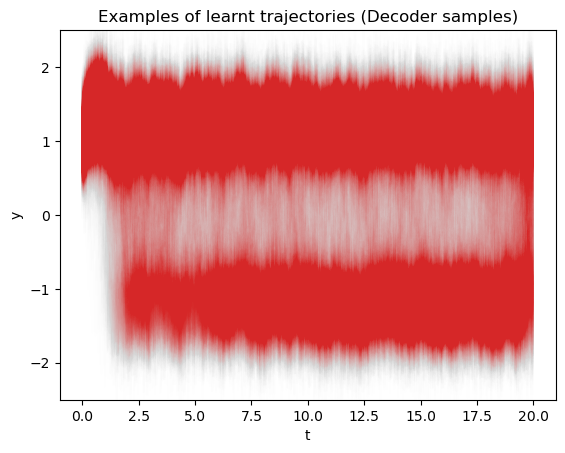

In [27]:
if args["trained_vae_path"] != "":
    trained_params = load_model_params(args["trained_vae_path"])
    decoder_params = trained_params['decoder']
else:
    decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (batch_size, latent_dim))

if decoder_twoheads:
    decoder = MLPDecoderTwoHeads(hidden_dim, out_dim, activation_fn)
    out_m, out_log_S = decoder.apply({'params': decoder_params}, z)      
else:
    decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
    out_m = decoder.apply({'params': decoder_params}, z) 
    out_log_S = jnp.log(vae_var * jnp.ones_like(out_m))

# sampling
out_std = jnp.exp(0.5 * out_log_S)
eps = jax.random.normal(rng, out_std.shape)
out = out_m + eps * out_std

for i in range(1000):
    plt.plot(sample_t_train[0], out[i,:], color="tab:red", alpha=0.005)

plt.xlabel('t')
plt.ylabel('y')
plt.ylim([-2.5, 2.5])
plt.title('Examples of learnt trajectories (Decoder samples)')

plt.show()

In [12]:
## Generate 1000 samples
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (2000, latent_dim))

if decoder_twoheads:
    decoder = MLPDecoderTwoHeads(hidden_dim, out_dim, activation_fn)
    out_m, out_log_S = decoder.apply({'params': decoder_params}, z)      
    # sampling
    out_std = jnp.exp(0.5 * out_log_S)
    eps = jax.random.normal(rng, out_std.shape)
    out = out_m + eps * out_std
else:
    decoder = MLPDecoder(hidden_dim, out_dim, activation_fn)
    out = decoder.apply({'params': decoder_params}, z)    

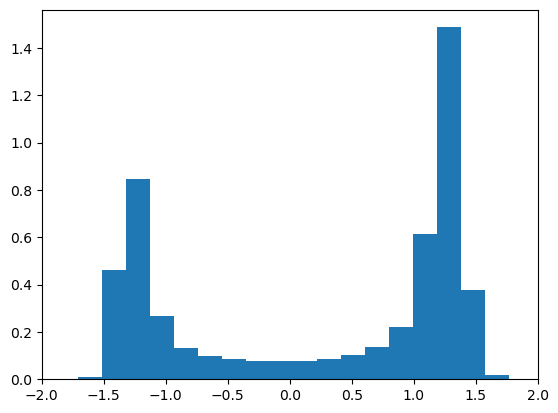

In [13]:
plt.hist(out.reshape(-1), bins=20, density=True)
plt.xlim([-2, 2])
plt.show()

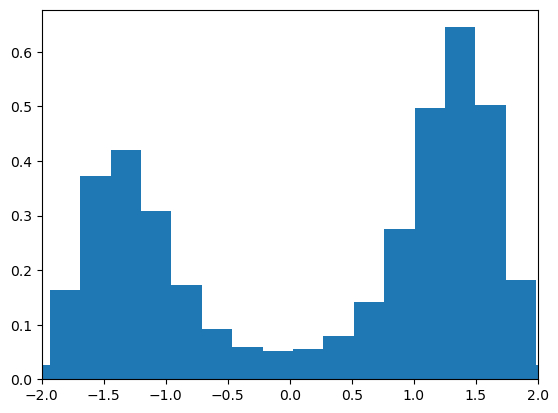

In [14]:
plt.hist(sample_y_train.reshape(-1), bins=20, density=True)
plt.xlim([-2, 2])
plt.show()

In [ ]:
# save_model_params("DW/16000_3_hidden", trainer.state.params)

## MCMC Inference

In [19]:
# Get observations
obs_full_t, obs_full_x, _ = sde_dataset_generator.simulatedata(1) 

# indices of data points for inference
obs_idx = jnp.linspace(obs_full_t[:, 0], obs_full_t[:, -1]/args["dt"], 10, dtype=jnp.int64).reshape((-1,))
obs_x = obs_full_x[:, obs_idx]
obs_t = obs_full_t[:, obs_idx]

Text(0.5, 1.0, 'Ground truth')

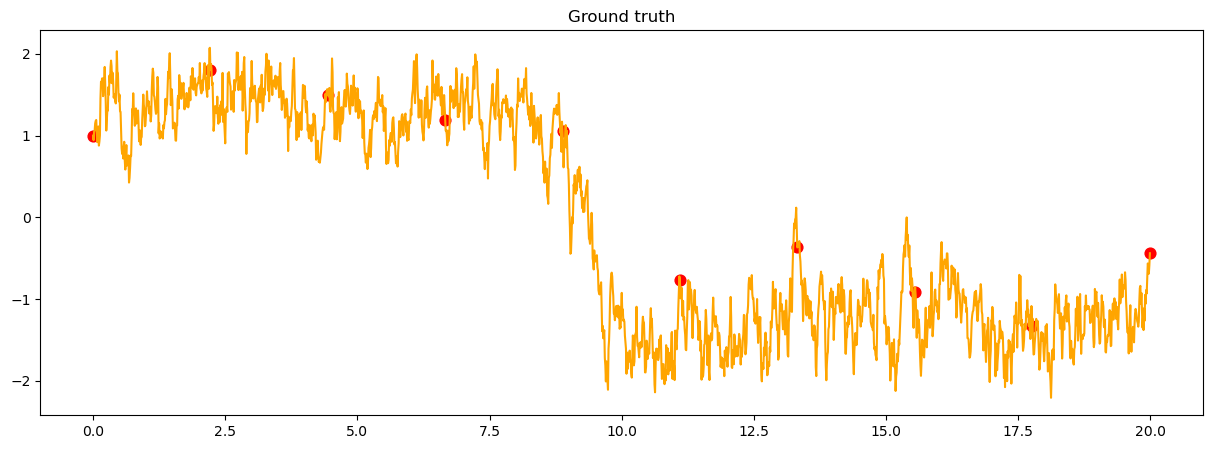

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(obs_full_t.reshape((-1, )), obs_full_x.reshape((-1, )), label="ground truth", color="orange")
plt.scatter(obs_t, obs_x, color="red", label="observed data", s=60)
plt.title('Ground truth')

In [21]:
# add data to args. This is used by MCMC.
args["y_obs"] = obs_x
args["obs_idx"] = obs_idx

In [22]:
rng_key_draw = jax.random.PRNGKey(rnd.randint(0, 9999))
rng_key, rng_key_post, rng_key_preds, rng_key_draw = jax.random.split(rng_key_draw, 4)

In [23]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, sample_decoder=False)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      1.00      0.00      1.00      1.00      1.00   7569.58      1.00
      f[1]      1.02      0.02      1.02      0.99      1.05   7974.23      1.00
      f[2]      1.05      0.03      1.05      1.00      1.10   7246.61      1.00
      f[3]      1.08      0.04      1.08      1.00      1.15   7079.74      1.00
      f[4]      1.07      0.06      1.08      0.97      1.16   7397.37      1.00
      f[5]      1.08      0.06      1.09      0.97      1.18   8129.29      1.00
      f[6]      1.08      0.07      1.09      0.93      1.19   7974.20      1.00
      f[7]      1.06      0.09      1.08      0.90      1.18   8032.37      1.00
      f[8]      1.08      0.10      1.11      0.90      1.22   8143.76      1.00
      f[9]      1.09      0.11      1.12      0.89      1.24   7924.48      1.00
     f[10]      1.10      0.12      1.13      0.87      1.26   7978.30      1.00
     f[11]      1.11      0

Average ESS for all VAE-GP effects : 8272


## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorVAE inference')

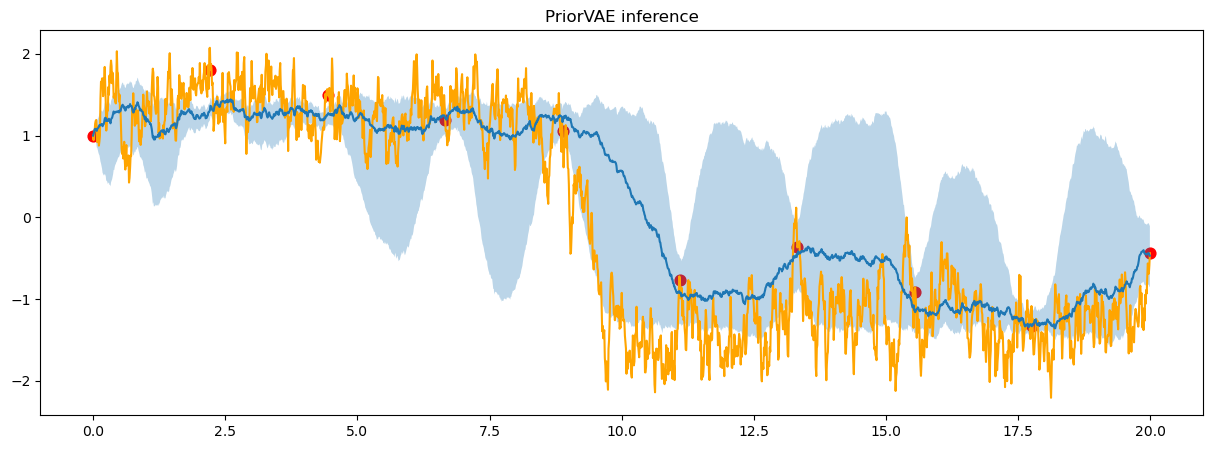

In [24]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params)["f"]
t = sample_t_train[0]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = jnp.percentile(predictions_vae, jnp.array([5.0, 95.0]), axis=0)

N_lines = 10

plt.figure(figsize=(15,5))
plt.plot(obs_full_t.reshape((-1, )), obs_full_x.reshape((-1, )), label="ground truth", color="orange")
plt.scatter(obs_t, obs_x, color="red", label="observed data", s=60)
plt.title('Ground truth')

plt.plot(t, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(t, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")


plt.title('PriorVAE inference')